In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TIMESTEP = 0.001 # needs to evenly divide 0.04, should match input to t_toss when called
FRAMERATE = 25 # FPS in original video, should be 25
prev_hand_kp = [0, 0]

In [3]:
def readfile(n):
    if n < 10:
        numstring = "000" + str(n)
    elif n < 100:
        numstring = "00" + str(n)
    elif n < 1000:
        numstring = "0" + str(n)
    else:
        numstring = str(n)

    filename = "~/Desktop/Expressive-MP/waypoints/arbor/arbor3_00000000" + numstring + "_keypoints.json"

    item = pd.read_json(filename)
    return item

def extract_angles(shoulder, elbow, wrist, fingertip):
    """
    Given the positions of the shoulder, elbow, wrist, 
    and fingertip, extract the three desired angles.
    """
    xdiff1 = elbow[0] - shoulder[0]
    ydiff1 = elbow[1] - shoulder[1]
    theta1 = np.arctan2(ydiff1, xdiff1)
    
    xdiff2 = wrist[0] - elbow[0]
    ydiff2 = wrist[1] - elbow[1]
    theta2 = np.arctan2(ydiff2, xdiff2)
    
    xdiff3 = fingertip[0] - wrist[0]
    ydiff3 = fingertip[1] - wrist[1]
    theta3 = np.arctan2(ydiff3, xdiff3)

    return [theta1, theta2, theta3]

def get_hand_kpt(d):
    """
    Hand keypoint detection is extremely noisy, so we do 
    the best we can and allow for lots of smoothing later.
    """
    global prev_hand_kp
    
    keypoints = d['hand_right_keypoints_2d']
    for i in [12, 16, 8, 20]:
        p = keypoints[3 * i: 3 * i + 2]
        if p[0] != 0 and p[1] != 0:
            prev_hand_kp = p
            return p
    return prev_hand_kp

def linear_interp(array, num):
    interpolated = array[0]
    for i in range(len(array) - 1):
        interp = np.linspace(array[i], array[i + 1], num)
        interpolated = np.vstack([interpolated, interp])
        
    return interpolated[1:]

def fourier_filter(array, thresh):
    fourier = np.fft.rfft(array)
    fourier[np.abs(fourier) < thresh] = 0
    filtered = np.fft.irfft(fourier)
    return filtered

def num_deriv(array, t):
    stack = None
    for a in array.T:
        grad = np.gradient(a, t, axis=0)
        stack = (grad if stack is None else np.vstack([stack, grad]))
    return stack.T

In [4]:
theta_list = []

for n in range(1345):
    d = readfile(n)["people"][0]
    if n == 0:
        print("OpenPose output:\n")
        print(d)
    series = d['pose_keypoints_2d']
    pt0 = series[0:2]
    pt1 = series[3:5]
    pt2 = series[6:8]
    pt3 = series[9:11]
    pt4 = series[12:14]
    hand_pt = get_hand_kpt(d)

    thetas = extract_angles(pt2, pt3, pt4, hand_pt)
    theta_list.append(thetas)

tl = np.array(theta_list)

OpenPose output:

{'person_id': [-1], 'pose_keypoints_2d': [601.955, 147.366, 0.7653369999999999, 631.337, 304.206, 0.49513399999999996, 427.591, 341.381, 0.253235, 310.021, 631.345, 0.234322, 0, 0, 0, 848.783, 286.523, 0.285661, 0, 0, 0, 0, 0, 0, 664.638, 715.585, 0.141056, 566.681, 699.916, 0.09795799999999999, 0, 0, 0, 0, 0, 0, 766.53, 692.079, 0.147979, 0, 0, 0, 0, 0, 0, 539.23, 84.7338, 0.845814, 664.552, 74.9607, 0.792692, 468.7, 131.705, 0.729607, 731.309, 106.268, 0.642726, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'face_keypoints_2d': [], 'hand_left_keypoints_2d': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'hand_right_keypoints_2d': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [5]:
tl[tl < 0] = tl[tl < 0] + 2 * np.pi
kernel = np.array([1, 2, 4, 6, 10, 14, 17, 19, 17, 14, 10, 6, 4, 2, 1])
#kernel = np.ones(9)
kernel = kernel / np.sum(kernel)

smoothed_thetas = np.vstack([np.convolve(tl[:, 0], kernel, mode='same'), 
                             np.convolve(tl[:, 1], kernel, mode='same'), 
                             np.convolve(tl[:, 2], kernel, mode='same')])

data = smoothed_thetas[:, 150:560] - np.pi / 2
t = np.arange(len(data[0])) / FRAMERATE

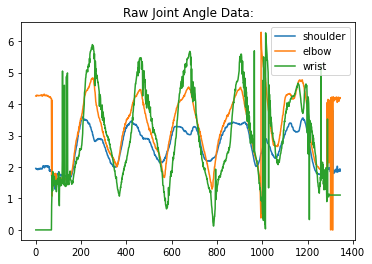

In [11]:
plt.plot(np.arange(len(tl)), tl[:, 0], label="shoulder")
plt.plot(np.arange(len(tl)), tl[:, 1], label="elbow")
plt.plot(np.arange(len(tl)), tl[:, 2], label="wrist")
plt.title("Raw Joint Angle Data:")
plt.legend()

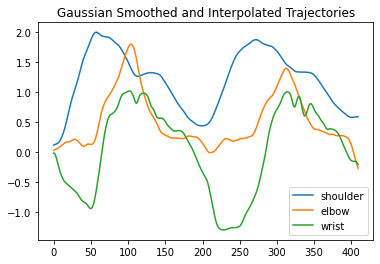

In [12]:
plt.plot(np.arange(len(data[0])), data[0], label="shoulder")
plt.plot(np.arange(len(data[0])), data[1] - data[0], label="elbow")
plt.plot(np.arange(len(data[0])), data[2] - data[1], label="wrist")
plt.title("Gaussian Smoothed and Interpolated Trajectories")
plt.legend()

In [13]:
# output = np.vstack([t, 
#                     np.zeros_like(t), 
#                     -data[0], 
#                     data[0] - data[1], 
#                     data[1] - data[2], 
#                     np.ones_like(t) * np.pi / 2,
#                     np.zeros_like(t)
#                    ]).T

# output = linear_interp(output, 20)
# output = np.hstack([output, np.zeros_like(output), np.zeros_like(output), np.zeros_like(output)])

# output = np.round_(output, decimals=5)
# np.savetxt("dance.dat", output, fmt="%10.5f", delimiter='\t')

In [14]:
sh = 0 - data[0]
el = data[0] - data[1]
wr = data[1] - data[2]

sh_filtered = fourier_filter(sh, 25)
el_filtered = fourier_filter(el, 15)
wr_filtered = fourier_filter(wr, 10)

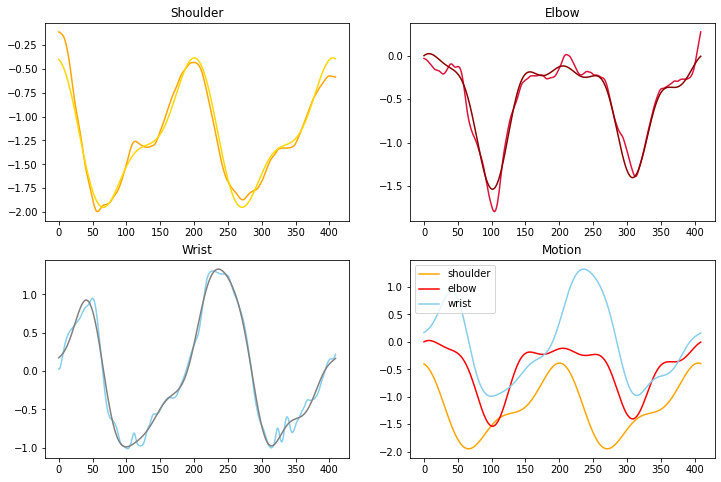

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(np.arange(len(data[0])), sh, label="shoulder signal", c="orange")
axs[0, 0].plot(np.arange(len(data[0])), sh_filtered, label="fourier filtered", c="gold")
axs[0, 0].set_title('Shoulder')
axs[0, 1].plot(np.arange(len(data[0])), el, label="elbow signal", c="crimson")
axs[0, 1].plot(np.arange(len(data[0])), el_filtered, label="fourier filtered", c="darkred")
axs[0, 1].set_title('Elbow')
axs[1, 0].plot(np.arange(len(data[0])), wr, label="wrist signal", c="skyblue")
axs[1, 0].plot(np.arange(len(data[0])), wr_filtered, label="fourier filtered", c="gray")
axs[1, 0].set_title('Wrist')
axs[1, 1].plot(np.arange(len(data[0])), sh_filtered, label="shoulder", c="orange")
axs[1, 1].plot(np.arange(len(data[0])), el_filtered, label="elbow", c="red")
axs[1, 1].plot(np.arange(len(data[0])), wr_filtered, label="wrist", c="skyblue")
axs[1, 1].set_title('Motion')
plt.legend(loc='upper left')
plt.show()

In [17]:
position = np.vstack([np.zeros_like(t), 
                      # np.sin(np.arange(len(data[0])) * 2 * np.pi / len(data[0])) * 0.5,
                      sh_filtered, 
                      el_filtered, 
                      wr_filtered, 
                      np.ones_like(t) * np.pi / 2,
                      np.zeros_like(t)
                     ]).T

position = linear_interp(position, int(1 / FRAMERATE / TIMESTEP))
t_int = linear_interp(t[np.newaxis].T, int(1 / FRAMERATE / TIMESTEP))

velocity = num_deriv(position, TIMESTEP)
acceleration = num_deriv(velocity, TIMESTEP)
jerk = num_deriv(acceleration, TIMESTEP)

output = np.hstack([t_int, position, velocity, acceleration, jerk])
output = np.round_(output, decimals=5)
np.savetxt("banana.dat", output, fmt="%10.5f", delimiter='\t')